# Importing Libraries

In [1]:
using MAT
using PyPlot
using ImageQuilting
using GeoStatsImages
using MultivariateStats
using JLD
using Plots
using Images, ImageView

#Custom functions stored in a library
include("./ImageQuiltingHelpers.jl/src/ImageQuiltingHelpers.jl")
using ImageQuiltingHelpers


# 1. Initializations and Unconditional Simulations

I start this by importing the data. You can see the format from the output of the next two cells.

In [2]:
#Import Matlab Data
fracdata=matread("complete processed data.mat")

Dict{String,Any} with 8 entries:
  "R2_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI4_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI2_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "R1_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "R4_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "R3_dmig"  => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI3_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…
  "TI1_dmig" => Dict{String,Any}(Pair{String,Any}("tmax", 3.99975e-8),Pair{Stri…

In [3]:
#Show an example of the fields for each struct, just for reference
fracdata["R2_dmig"]

Dict{String,Any} with 22 entries:
  "tmax"          => 3.99975e-8
  "sTI"           => [0.00156502 0.00161257 … 0.00164644 0.00162116; 0.00164226…
  "x"             => [-0.042 -0.04 … 2.04 2.042]
  "dt"            => 7.5e-12
  "binary"        => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0…
  "env"           => [0.00156502 0.00161257 … 0.00164644 0.00162116; 0.00158022…
  "dmig"          => [-0.000398511 -0.000783725 … -0.000109158 -0.000812116; -0…
  "srcloc_x"      => [3.46945e-17 0.048 … 1.448 1.5]
  "zmig"          => [0.0 0.00042 … 2.11344 2.11386]
  "eps"           => [1.0 1.0 … 7.0 7.0; 1.0 1.0 … 7.0 7.0; … ; 1.0 1.0 … 7.0 7…
  "frequency_MHz" => 500.0
  "srcpulse"      => [5.43e-7 8.14486e-6 … 0.0 0.0]
  "mu"            => [1.0 1.0 … 1.025 1.025; 1.0 1.0 … 1.025 1.025; … ; 1.0 1.0…
  "recloc_x"      => [0.5 0.548 … 1.948 2.0]
  "z"             => [-0.102 -0.1 … 2.04 2.042]
  "pTI"           => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0…
  "npml"   

Next we prepare the data that I use in the simulations. I have created the function *prepareImages* as a part of the ImageQuiltingHelpers library to do this concisely for me. This function reads a set from the custom-formatted data and does 4 things. 

* Clips the x-axis of the primary TI to match the range of the secondary information

* Interpolates the secondary information to match the dimensions of the clipped TI

* Performs the proximity transform on the clipped primary information

* Convert the above 3 images to training images (add a ghost dimension) and return the 3 images

These three steps each return an image, hence the three outputs that you can see below. Each image is the same size so they can be used directly in simulations. We also define the number of realizations for the conditional and unconditional simulations in the following cell.

In [4]:
#Prepare all my data to have matching sizes before simulating
TI_prim, TI_aux, TI_prox = prepareImages(fracdata["TI2_dmig"]);
R_prim, R_aux, R_prox = prepareImages(fracdata["R2_dmig"]);

#Number of realizations
n=100;

Now we can start plotting and simulating. We perform the unconditional simulations using the binary image first. The next cell just plots the trianing image, the second performs the simulation, the third uses a custom function to save the results, and the fourth plots a summary of the realizations.

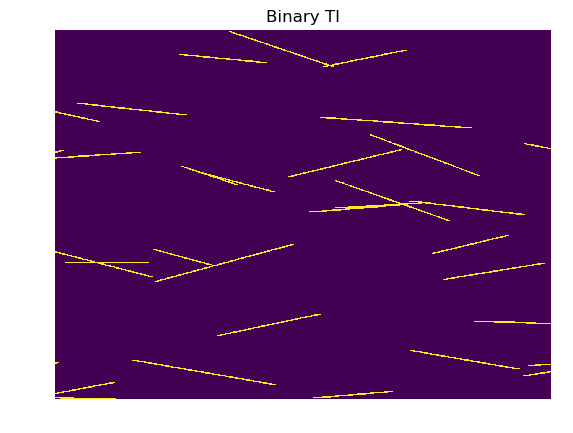

In [5]:
#Plot binary training image
plotImage(TI_prim);
title("Binary TI");
axis("off");

In [6]:
#  Perform unconditional simulation on binary image
t_binary_uncond=[250 250 1]
binary_uncond = load("Simulations/binary_uncond_sim.jld")["sim"]["Realizations"]
binary_uncond_mean, binary_uncond_stdev, binary_uncond_entropy=realizationStats(binary_uncond);

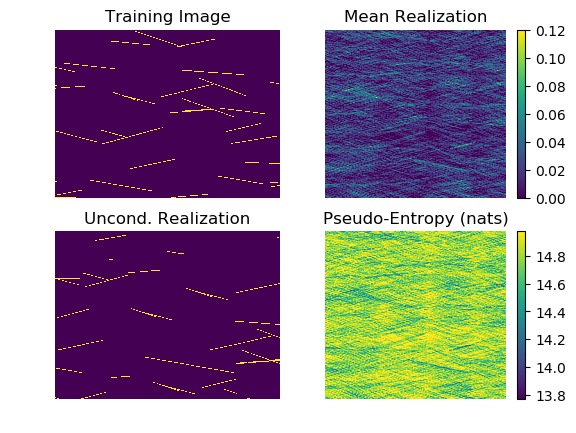

In [7]:
#Plot realization
subplot(2,2,1)
plotImage(TI_prim)
axis("off")
title("Training Image")
subplot(2,2,3)
plotImage(binary_uncond[1][:,:,1])
axis("off")
title("Uncond. Realization")
subplot(2,2,2)
plotImage(binary_uncond_mean)
axis("off")
title("Mean Realization")
colorbar()
subplot(2,2,4)
plotImage(binary_uncond_entropy)
axis("off")
title("Pseudo-Entropy (nats)")
colorbar()
;

The next four cells do the same thing as the previous four, but with the proximity-transformed training image.

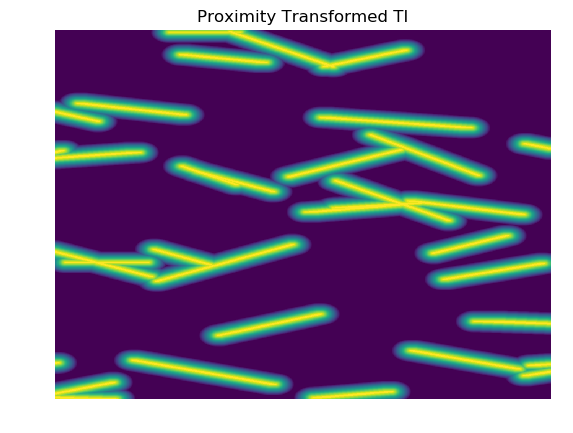

In [8]:
#Plot proximity transform training image
plotImage(TI_prox);
title("Proximity Transformed TI");
axis("off");

In [9]:
#  Perform test IQ Simulation on proximity-transformed image
t_prox_uncond=[120 120 1]
prox_uncond = load("Simulations/prox_uncond_sim.jld")["sim"]["Realizations"]
prox_uncond_mean, prox_uncond_stdev, prox_uncond_entropy=realizationStats(prox_uncond);

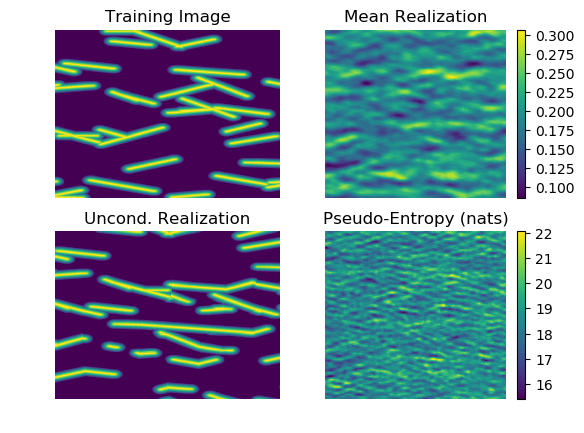

In [10]:
#  Plot realization
subplot(2,2,1)
plotImage(TI_prox)
axis("off")
title("Training Image")
subplot(2,2,3)
plotImage(prox_uncond[1][:,:,1])
axis("off")
title("Uncond. Realization")
subplot(2,2,2)
plotImage(prox_uncond_mean)
axis("off")
title("Mean Realization")
colorbar()
subplot(2,2,4)
plotImage(prox_uncond_entropy)
axis("off")
title("Pseudo-Entropy (nats)")
colorbar()
;

**Brief Discussion**

This image quilting technique is really incredible. I can't believe how fast it is and how it produces much more visually appealing images than typical MPS simulations. One slightly concerning observation is that this algorithm, at least with this template size, sometimes produces much longer fractures than the training image contains. I have a feeling this is a template size phenomenon but nonetheless something worth noting. Also, the algorithm works basically the same for data with and without the proximity transform.  

# 2. Template Size Testing

In this next part we examine the effect of template size on the unconditional realizations. We begin by simply generating some realizations for a visual analysis.

In [11]:
#Define template sizes
templSizes=[51 51 1; 76 76 1; 101 101 1; 201 201 1];

In [12]:
#Template size test without proximity transform
binary_templSizeTest=load("Simulations/binary_uncond_templSizeTest.jld")["sim"]["Realizations"]

#With proximity transform
prox_templSizeTest=load("Simulations/prox_uncond_templSizeTest.jld")["sim"]["Realizations"];

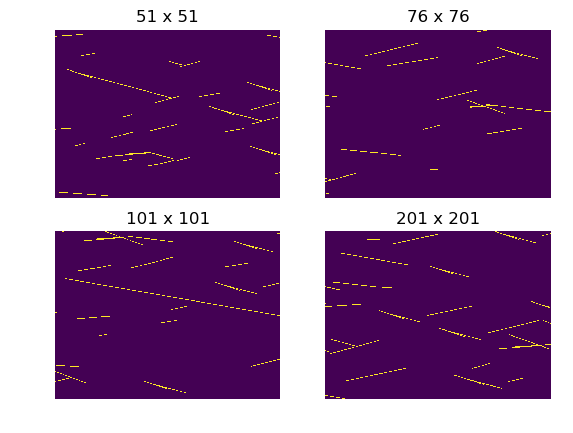

In [13]:
#Plot template size test results (realization 1) for binary
titles=["51 x 51", "76 x 76", "101 x 101", "201 x 201"]
for i=1:4
    subplot(2,2,i)
    plotImage(binary_templSizeTest[i][1][:,:,1])
    axis("off")
    title(titles[i])
end

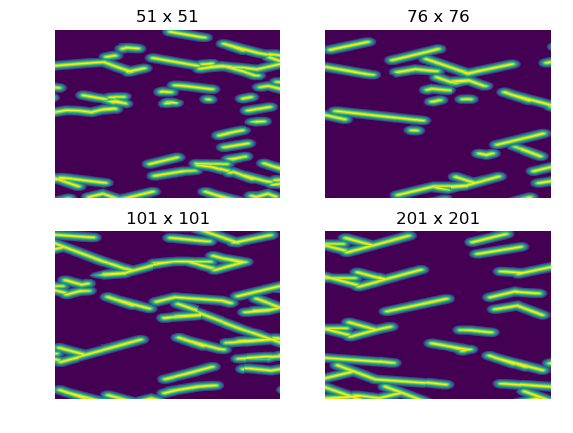

In [14]:
#Plot template size test results for proximity transform
for i=1:4
    subplot(2,2,i)
    plotImage(prox_templSizeTest[i][1][:,:,1])
    axis("off")
    title(titles[i])
end

We can go further and actually quantitatively assess what template size we should be using by analyzing voxel reuse plots. These plots show the mean number of voxels that are not overwritten in each simulation. The template sizes yielding the highest mean voxel reuse are the best template sizes to use. 

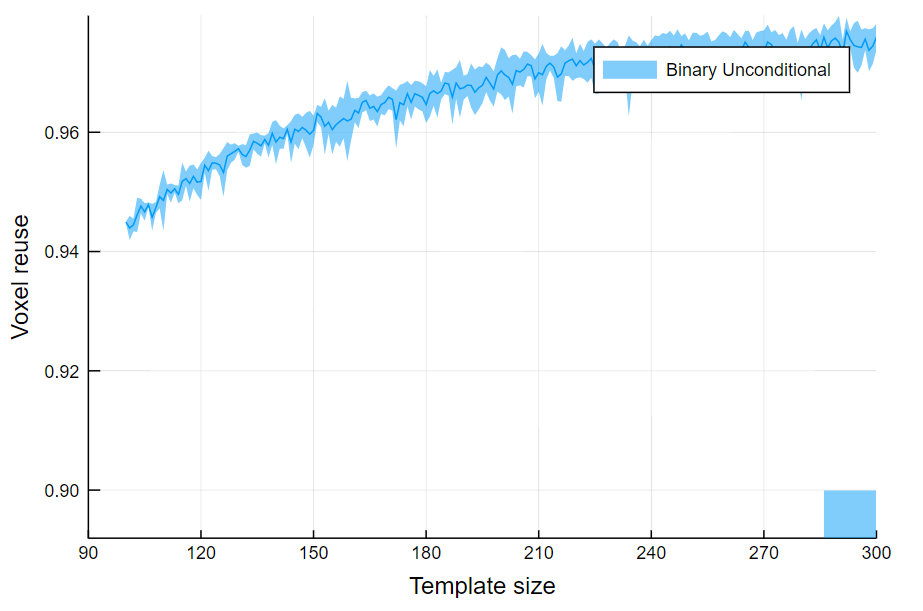

In [15]:
VR_binary_uncond=load("Figures/vr_binary_uncond.png")

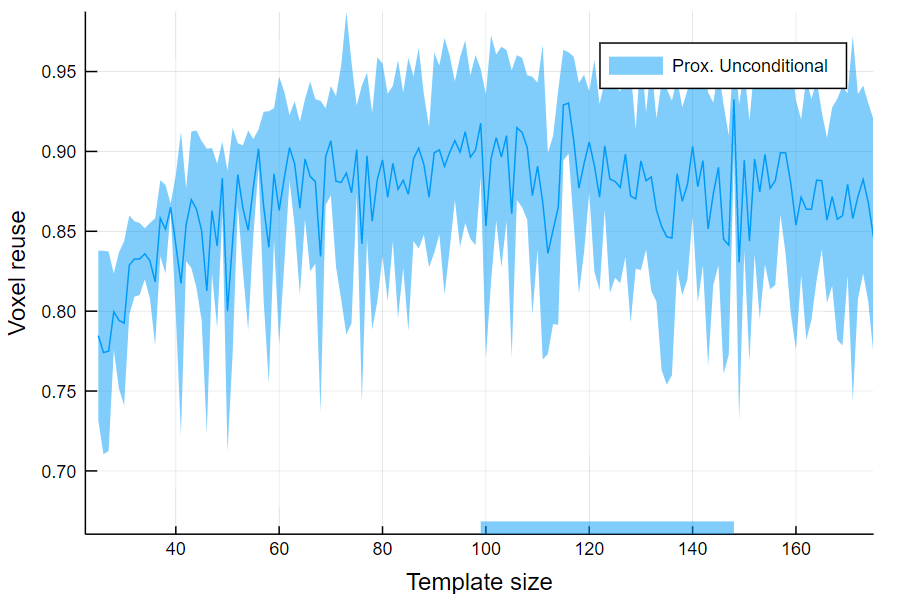

In [16]:
VR_prox_uncond=load("Figures/vr_prox_uncond.png")

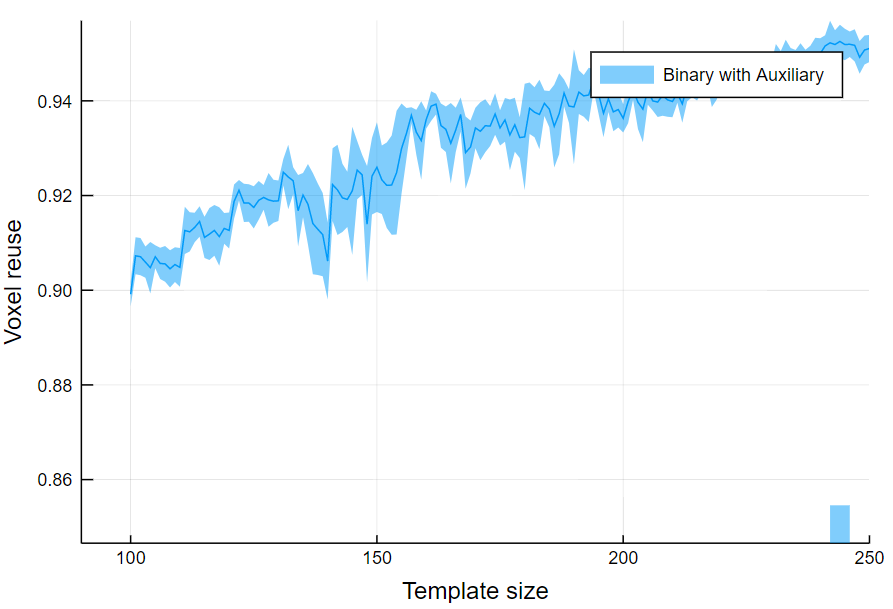

In [17]:
VR_binary_cond=load("Figures/vr_binary_cond.png")

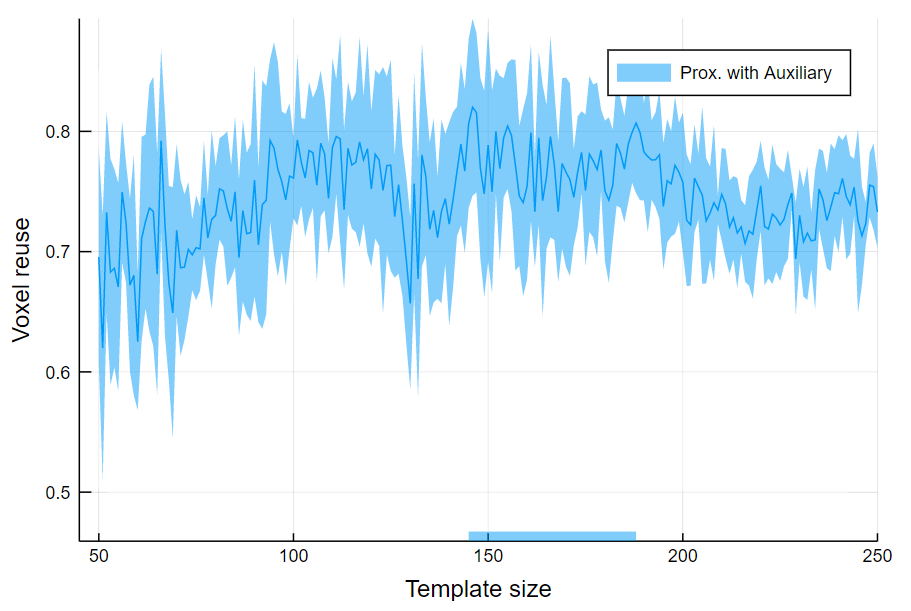

In [18]:
VR_prox_cond=load("Figures/vr_prox_cond.png")

**Brief Discussion**

So there's a couple of neat things going on here. First looking at the example realizations we can observe that too small of a template tends to produce too short of fractures compared to the training image. So clearly template size does play a role in the quality of the realizations. Also the proximity-transformed images seem more sensitive to the template size, requiring a large template to reproduce the fracture network.

The voxel reuse plots provide more insight into this. First, we notice that the binary unconditional simulation has a very high voxel reuse at all template sizes. This can't be too surprising since the image has very few yellow pixels in the first place. However it appears that most template sizes will work pretty well for this case. 

The voxel reuse plots for the proximity-transformed unconditional simulations show much more variance in voxel reuse because it is much more difficult to stitch together larger features. On this plot we actually see a clear decrease in voxel reuse after a certain point, around a template size of 120 or so. So for this image we should use a smaller template than we would for the binary image.

Now we turn to the conditional simulations. We can see that both sets of conditional simulations have a lower voxel reuse because of the auxiliary data constraint. As with the unconditional simulations binary image has a higher and less variable voxel reuse than the proximity-transformed image. It also seems like the conditional simulations are optimal with a larger template size compared to the unconditional simulations. 

We will use these observations to guide the unconditional and conditional simulation templates.

# 3. Using Secondary Data

Now we can begin the meat of the project. Here we will try to reproduce a fracture image based on some geophysical data. We use a Training Image primary/auxiliary pair and condition the realizations on another auxiliary data set. The goal is to reproduce the reference, or true, image. 

The geophysical data is from a Ground-Penetrating Radar (GPR) simulation of a fracture network. The simulation assumed that the fractures had an aperture of 8mm (or cm, I can't remember). The host rock is granitic and the fractures contain water. Up to this point the GPR data has been gained based on depth, migrated using a constant velocity model, and enveloped to smooth the image. This is a simple processing workflow as the processing is not the major focus of this work.

Below we perform conditional simulations, save the results, and show a summary of the results. We simulate both the binary image and the proximity-transformed image.

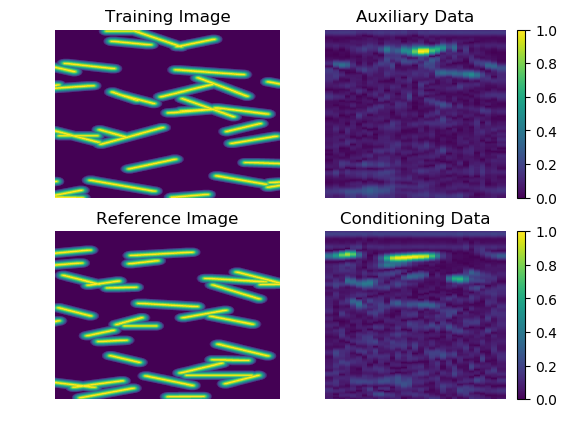

In [19]:
#Show training, conditioning, and reference images.
subplot(2,2,1)
plotImage(TI_prox[:,:,1])
axis("off")
title("Training Image")
subplot(2,2,2)
plotImage(TI_aux[:,:,1])
axis("off")
title("Auxiliary Data")
colorbar()
subplot(2,2,3)
plotImage(R_prox[:,:,1])
axis("off")
title("Reference Image")
subplot(2,2,4)
plotImage(R_aux[:,:,1])
axis("off")
title("Conditioning Data")
colorbar()
;

In [20]:
#Conditional image quilting simulation - no proximity transform
t_binary_cond=[250 250 1]
binary_cond=load("Simulations/binary_cond_sim.jld")["sim"]["Realizations"]

#Conditional image quilting simulation with proximity transform
t_prox_cond=[160 160 1]
prox_cond=load("Simulations/prox_cond_sim.jld")["sim"]["Realizations"]

#Compute mean & stdev of realizations
binary_cond_mean, binary_cond_stdev, binary_cond_entropy=realizationStats(binary_cond)
prox_cond_mean, prox_cond_stdev, prox_cond_entropy=realizationStats(prox_cond);

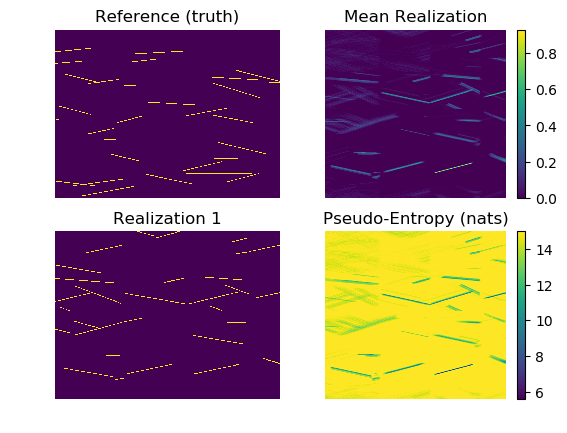

In [21]:
#Summarize binary conditional simulation
subplot(2,2,1)
plotImage(R_prim)
axis("off")
title("Reference (truth)")
subplot(2,2,3)
plotImage(binary_cond[1][:,:,1])
axis("off")
title("Realization 1")
subplot(2,2,2)
plotImage(binary_cond_mean)
axis("off")
title("Mean Realization")
colorbar()
subplot(2,2,4)
plotImage(binary_cond_entropy)
axis("off")
title("Pseudo-Entropy (nats)")
colorbar()
;

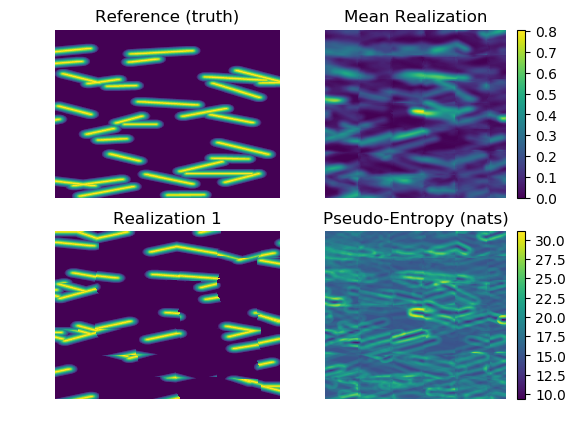

In [22]:
#Summarize proximity conditional simulation
subplot(2,2,1)
plotImage(R_prox)
axis("off")
title("Reference (truth)")
subplot(2,2,3)
plotImage(prox_cond[1][:,:,1])
axis("off")
title("Realization 1")
subplot(2,2,2)
plotImage(prox_cond_mean)
axis("off")
title("Mean Realization")
colorbar()
subplot(2,2,4)
plotImage(prox_cond_entropy)
axis("off")
title("Pseudo-Entropy (nats)")
colorbar()
;

We can also compare this to previous MPS simulation results using *wavesim*. These results are from a binary simulation on a resampled version of the binary TI above. The resampling was performed for a few reasons: (a) so the dimensions of the primary and secondary images matched and (2) to reduce computational time. The *wavesim* algorithm, written in Matlab, was very slow compared to this image quilting simulation and therefore reducing the size of the image was the only feasible way of performing a simulation. 

Below you can see the results of the simulation.

In [23]:
#Import wavesim results with custom function
cond_wavesim=load_wavesim_results(fracdata);

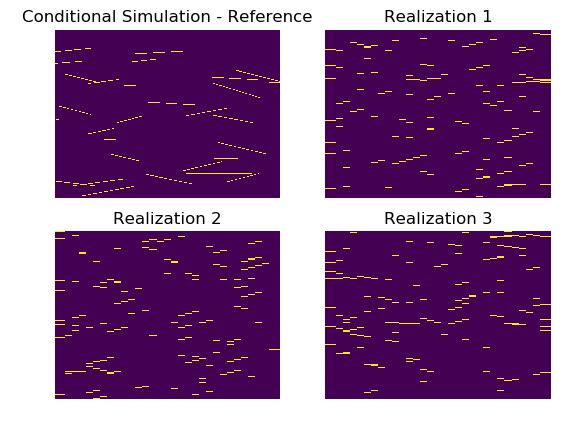

In [24]:
#Plot Wavesim realizations
subplot(2,2,1)
plotImage(R_prim)
axis("off")
title("Conditional Simulation - Reference")
for i=1:3
    subplot(2,2,i+1)
    plotImage(cond_wavesim[i][:,:,1])
    axis("off")
    title("Realization $(i)")
end
;

**Brief Discussion**

...

# 4. Assess Spatial Uncertainty

Now we introduce a methodology for quantifying the simulation results. The method is based on a Principal Coordinate Analysis, also known as MultiDimensional Scaling. 

First we compute a distance matrix for all the simulations using the custom function *distMat*. This function takes realizations, the training image, and the reference image and computes the Euclidean distance between all of them. We can use this distance matrix to perform MDS. For the binary images we apply a proximity transform before computing the distances. 

After this we compute the percent variance for the MDS coordinates and display the MDS results for the binary and proximity-transformed data.

In [25]:
#Same for binary simulations, but we apply prox transform to realizations first
input=vcat(realProxTrans(binary_uncond),realProxTrans(binary_cond),realProxTrans(cond_wavesim))
D_binary=distMat(input,TI_prox,R_prox)
mds_binary=classical_mds(D_binary,2);

#Compute distance matrix for proximity-transformed simulations and perform MDS
D_prox=distMat(vcat(prox_uncond,prox_cond),TI_prox,R_prox)
mds_prox=classical_mds(D_prox,2);

In [26]:
#This function computes the percent variance array
#Not sure why the built-in function doesn't do it
#but it's not too hard to do myself. 
function computePercentVariance(Dist)
    G=dmat2gram(Dist)
    va,ve=eig(G)
    pv=va./sum(va)
    return  pv[end:-1:1]
end
;

In [27]:
#Percent Variance
pv_binary=computePercentVariance(D_binary)
pv_prox=computePercentVariance(D_prox);

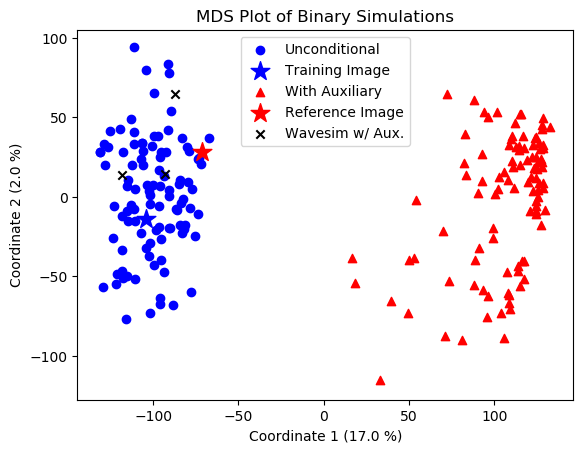

In [28]:
#Plot the results of the MDS for binary simulations
s1=PyPlot.scatter(mds_binary[1,1:n],mds_binary[2,1:n],marker="o",c="b")
s2=PyPlot.scatter(mds_binary[1,n+1:n*2],mds_binary[2,n+1:n*2],marker="^",c="r")
s3=PyPlot.scatter(mds_binary[1,end-1],mds_binary[2,end-1],marker="*",s=200,c="b")
s4=PyPlot.scatter(mds_binary[1,end],mds_binary[2,end],marker="*",s=200,c="r")
s5=PyPlot.scatter(mds_binary[1,n*2+1:n*2+3],mds_binary[2,n*2+1:n*2+3],marker="x",c="k")

legend((s1,s3,s2,s4,s5),("Unconditional","Training Image","With Auxiliary","Reference Image","Wavesim w/ Aux."))
xlabel("Coordinate 1 ($(round(pv_binary[1]*100)) %)")
ylabel("Coordinate 2 ($(round(pv_binary[2]*100)) %)")
title("MDS Plot of Binary Simulations")
;

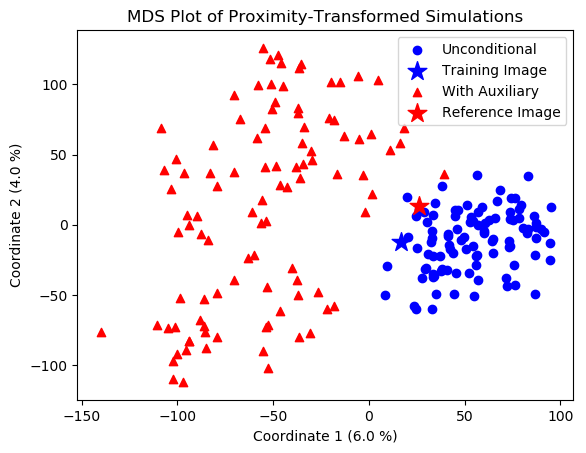

In [29]:
#Plot the results of the MDS for proximity-transformed simulations
s1=PyPlot.scatter(mds_prox[1,1:n],mds_prox[2,1:n],marker="o",c="b")
s2=PyPlot.scatter(mds_prox[1,n+1:n*2],mds_prox[2,n+1:n*2],marker="^",c="r")
s3=PyPlot.scatter(mds_prox[1,end-1],mds_prox[2,end-1],marker="*",s=200,c="b")
s4=PyPlot.scatter(mds_prox[1,end],mds_prox[2,end],marker="*",s=200,c="r")

legend((s1,s3,s2,s4),("Unconditional","Training Image","With Auxiliary","Reference Image"))
xlabel("Coordinate 1 ($(round(pv_prox[1]*100)) %)")
ylabel("Coordinate 2 ($(round(pv_prox[2]*100)) %)")
title("MDS Plot of Proximity-Transformed Simulations")
;

**Brief Discussion**

Well on the MDS plots both the binary and proximity-transformed simulations show clear separation. However, the principal coordinates for proximity-transformed simulations all have similar variance so they do not necessarily mean much. 

On the binary simulations the first principal component contributes to a relatively large portion of the variance and there is clear separation between the unconditional and conditional results along this coordinate. This is strong evidence that there really is some sort of difference between the two simulations. However, the reference image is still statistically closer to the unconditional simulations than the conditional ones. 

Less important but still neat is that the conditional *wavesim* realizations are just the same as unconditional image quilting realizations. Clearly we have made a large improvement with this method.

# 5. Using Uniform Score Transform

Now we will explore the effects of some additional post-processing of our geophysical data. Particularly, we will be using a procedure referred to as the Uniform Score Transform (UST). The uniform score transform takes the data of any distribution and converts it to a uniform distribution while preserving the order of the data. In simpler terms, we sort the data then replace each sample with its rank in the sorting. We can normalize by dividing by the number of samples in our data. This allows us to preserve the amplitude relationships such that the weak reflectors at the bottom of the auxiliary images are amplified. 

Below are plots of the data that will be used for the next round of conditional simulations. The auxiliary images used as conditioning data are now uniform-score transformed.

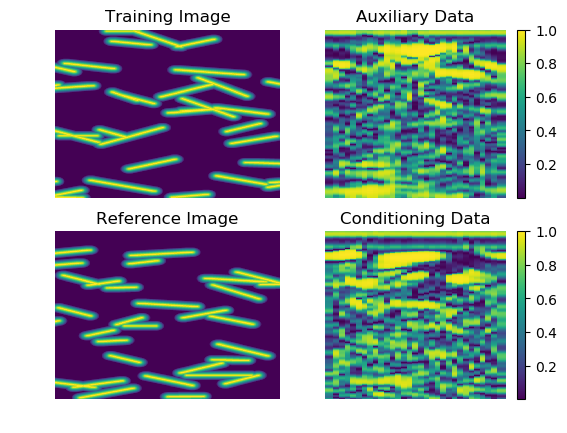

In [30]:
subplot(2,2,1)
plotImage(TI_prox[:,:,1])
axis("off")
title("Training Image")
subplot(2,2,2)
plotImage(ust(TI_aux))
axis("off")
title("Auxiliary Data")
colorbar()
subplot(2,2,3)
plotImage(R_prox[:,:,1])
axis("off")
title("Reference Image")
subplot(2,2,4)
plotImage(ust(R_aux))
axis("off")
title("Conditioning Data")
colorbar()
;

Now we can run our simulations and examine the results.

In [31]:
#Conditional image quilting simulation - no proximity transform
binary_cond_ust=load("Simulations/binary_cond_ust_sim.jld")["sim"]["Realizations"]

#Conditional image quilting simulation with proximity transform
prox_cond_ust=load("Simulations/prox_cond_ust_sim.jld")["sim"]["Realizations"]

#Compute mean & stdev of realizations
binary_cond_ust_mean, binary_cond_ust_stdev, binary_cond_ust_entropy=realizationStats(binary_cond_ust)
prox_cond_ust_mean, prox_cond_ust_stdev, prox_cond_ust_entropy=realizationStats(prox_cond_ust);

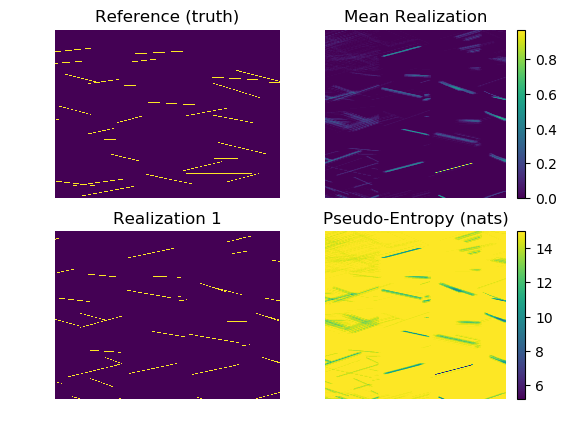

In [32]:
#Plot binary UST conditional sims
subplot(2,2,1)
plotImage(R_prim)
axis("off")
title("Reference (truth)")
subplot(2,2,3)
plotImage(binary_cond_ust[1][:,:,1])
axis("off")
title("Realization 1")
subplot(2,2,2)
plotImage(binary_cond_ust_mean)
axis("off")
title("Mean Realization")
colorbar()
subplot(2,2,4)
plotImage(binary_cond_ust_entropy)
axis("off")
title("Pseudo-Entropy (nats)")
colorbar()
;

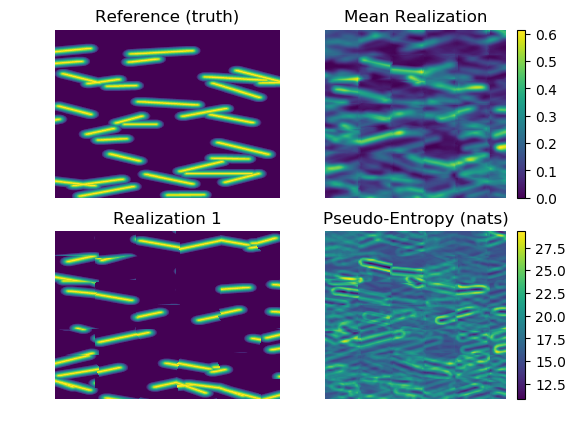

In [33]:
#Plot prox UST conditional sims
subplot(2,2,1)
plotImage(R_prox)
axis("off")
title("Reference (truth)")
subplot(2,2,3)
plotImage(prox_cond_ust[1][:,:,1])
axis("off")
title("Realization 1")
subplot(2,2,2)
plotImage(prox_cond_ust_mean)
axis("off")
title("Mean Realization")
colorbar()
subplot(2,2,4)
plotImage(prox_cond_ust_entropy)
axis("off")
title("Pseudo-Entropy (nats)")
colorbar()
;

In [34]:
#Compute distance matrix for proximity-transformed simulations and perform MDS
D_prox_ust=distMat(vcat(prox_uncond,prox_cond_ust,prox_cond),TI_prox,R_prox)
mds_prox_ust=classical_mds(D_prox_ust,2);

#Same for binary simulations, but we apply prox transform to realizations first
input=vcat(realProxTrans(binary_uncond),realProxTrans(binary_cond_ust),realProxTrans(binary_cond))
D_binary_ust=distMat(input,TI_prox,R_prox)
mds_binary_ust=classical_mds(D_binary_ust,2);


In [35]:
pv_prox_ust=computePercentVariance(D_prox_ust)
pv_binary_ust=computePercentVariance(D_binary_ust);

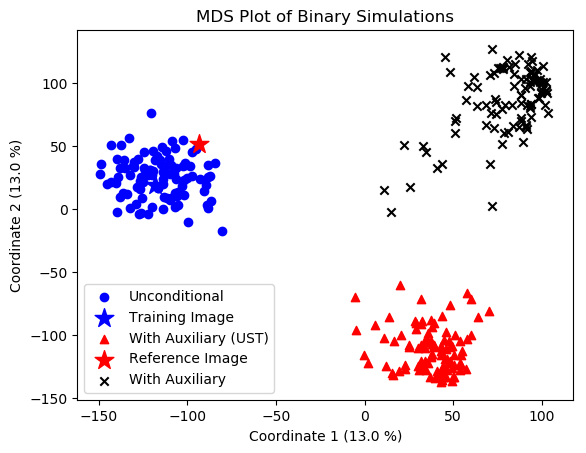

In [36]:
#Plot the results of the MDS for binary simulations
s1=PyPlot.scatter(mds_binary_ust[1,1:n],mds_binary_ust[2,1:n],marker="o",c="b")
s2=PyPlot.scatter(mds_binary_ust[1,n+1:n*2],mds_binary_ust[2,n+1:n*2],marker="^",c="r")
s3=PyPlot.scatter(mds_binary_ust[1,end-1],mds_binary_ust[2,end-1],marker="*",s=200,c="b")
s4=PyPlot.scatter(mds_binary_ust[1,end],mds_binary_ust[2,end],marker="*",s=200,c="r")
s5=PyPlot.scatter(mds_binary_ust[1,n*2+1:n*3],mds_binary_ust[2,n*2+1:n*3],marker="x",c="k")

legend((s1,s3,s2,s4,s5),("Unconditional","Training Image","With Auxiliary (UST)","Reference Image","With Auxiliary"))
xlabel("Coordinate 1 ($(round(pv_binary_ust[1]*100)) %)")
ylabel("Coordinate 2 ($(round(pv_binary_ust[2]*100)) %)")
title("MDS Plot of Binary Simulations")
;

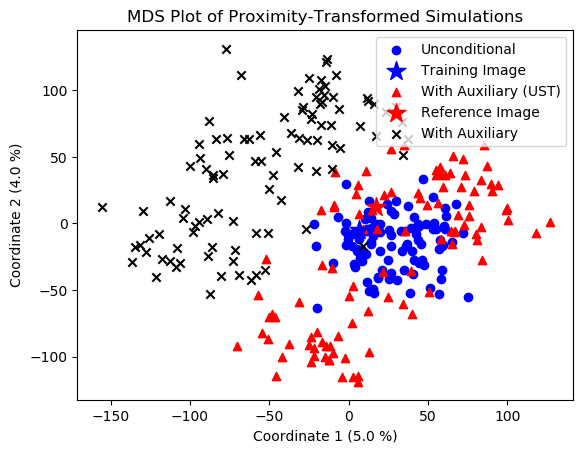

In [37]:
#Plot the results of the MDS for proximity-transformed simulations
s1=PyPlot.scatter(mds_prox_ust[1,1:n],mds_prox_ust[2,1:n],marker="o",c="b")
s2=PyPlot.scatter(mds_prox_ust[1,n+1:n*2],mds_prox_ust[2,n+1:n*2],marker="^",c="r")
s5=PyPlot.scatter(mds_prox_ust[1,n*2+1:n*3],mds_prox_ust[2,n*2+1:n*3], marker="x",c="k")
s3=PyPlot.scatter(mds_prox_ust[1,end-1],mds_prox_ust[2,end-1],marker="*",s=200,c="b")
s4=PyPlot.scatter(mds_prox_ust[1,end],mds_prox_ust[2,end],marker="*",s=200,c="r")

legend((s1,s3,s2,s4,s5),("Unconditional","Training Image","With Auxiliary (UST)","Reference Image","With Auxiliary"))
xlabel("Coordinate 1 ($(round(pv_prox_ust[1]*100)) %)")
ylabel("Coordinate 2 ($(round(pv_prox_ust[2]*100)) %)")
title("MDS Plot of Proximity-Transformed Simulations")
;


**Brief Discussion**

Again we find that the variance on the proximity-transformed simulations is very low for the first two coordinates. The binary simulations are again much higher. We do get some sweet separation between our three different binary simulations but again the conditionals are biased away from the truth. 